In [ ]:
import tensorflow as tf 
import numpy as np
import os
import time
import io
import matplotlib.pyplot as plt

In [ ]:
with io.open('shakespeare_train.txt','r',encoding='utf8') as f:
    text = f.read()

with io.open('shakespeare_valid.txt','r',encoding='utf8') as f:
    text_v = f.read()
    
vocab = set(text)

vocab_to_int = {c:i for i, c in enumerate(vocab)}
int_to_vocab = dict(enumerate(vocab))
text_as_int = np.array([vocab_to_int[c] for c in text],dtype=np.int32)
text_v_as_int = np.array([vocab_to_int[c] for c in text_v],dtype=np.int32)


In [ ]:
seq_length = 100
tr_dataset = tf.data.Dataset.from_tensor_slices(text_as_int)
va_dataset = tf.data.Dataset.from_tensor_slices(text_v_as_int)
sequences_tr = tr_dataset.batch(seq_length+1, drop_remainder=True)
sequences_va = va_dataset.batch(seq_length+1, drop_remainder=True)

In [ ]:
def split_input_target(chunk):
    input_text = chunk[:-1]
    target_text = chunk[1:]
    return input_text, target_text
dataset_tr = sequences_tr.map(split_input_target)
dataset_va = sequences_va.map(split_input_target)

In [ ]:
batch_s = 64
buffer = 10000
dataset_tr = dataset_tr.shuffle(buffer).batch(batch_s, drop_remainder=True)
dataset_va = dataset_va.batch(batch_s, drop_remainder=True)

<BatchDataset element_spec=(TensorSpec(shape=(64, 100), dtype=tf.int32, name=None), TensorSpec(shape=(64, 100), dtype=tf.int32, name=None))>

In [ ]:
def build_modelx(vocab_size, embedding_dim, rnn_units, batch_size):
  model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim,
                              batch_input_shape=[batch_size, None]),
    tf.keras.layers.SimpleRNN(rnn_units,
                        return_sequences=True,
                        stateful=True),
    tf.keras.layers.Dense(vocab_size)
  ])
  return model

In [ ]:
def loss(labels, logits):
      return (tf.experimental.numpy.log2(abs(logits))) * (tf.one_hot(labels,67))

In [ ]:
modelx = build_modelx(vocab_size = 67,embedding_dim=256,rnn_units=512,batch_size=batch_s)
modelx.compile(optimizer='adam', loss=loss, metrics = ['accuracy'])

In [ ]:
checkpoint_dir = './training_checkpoints1'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt_{epoch}")
checkpoint_callback=tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_prefix,save_weights_only=True)

In [ ]:
EPOCHS=30
historyx = modelx.fit(dataset_tr, epochs=EPOCHS, validation_data = dataset_va,callbacks=[checkpoint_callback])

Epoch 1/30
673/673 [==============================] - 66s 95ms/step - loss: 2.1893 - accuracy: 0.3796 - val_loss: 1.8768 - val_accuracy: 0.4491
Epoch 2/30
673/673 [==============================] - 64s 94ms/step - loss: 1.7122 - accuracy: 0.4943 - val_loss: 1.6935 - val_accuracy: 0.4960
Epoch 3/30
673/673 [==============================] - 64s 94ms/step - loss: 1.5746 - accuracy: 0.5299 - val_loss: 1.6242 - val_accuracy: 0.5146
Epoch 4/30
673/673 [==============================] - 63s 91ms/step - loss: 1.5093 - accuracy: 0.5462 - val_loss: 1.5910 - val_accuracy: 0.5285
Epoch 5/30
673/673 [==============================] - 62s 91ms/step - loss: 1.4704 - accuracy: 0.5558 - val_loss: 1.5715 - val_accuracy: 0.5302
Epoch 6/30
673/673 [==============================] - 62s 91ms/step - loss: 1.4445 - accuracy: 0.5618 - val_loss: 1.5565 - val_accuracy: 0.5352
Epoch 7/30
673/673 [==============================] - 60s 88ms/step - loss: 1.4255 - accuracy: 0.5666 - val_loss: 1.5433 - val_accuracy:

In [ ]:
modelx.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (64, None, 256)           17152     
                                                                 
 simple_rnn_2 (SimpleRNN)    (64, None, 512)           393728    
                                                                 
 dense_2 (Dense)             (64, None, 67)            34371     
                                                                 
Total params: 445,251
Trainable params: 445,251
Non-trainable params: 0
_________________________________________________________________


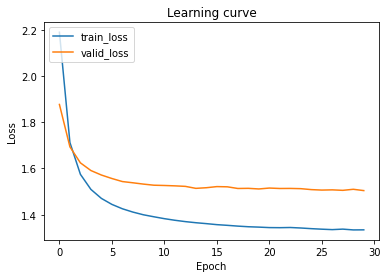

In [ ]:
plt.plot(historyx.history['loss'])
plt.plot(historyx.history['val_loss'])
plt.title('Learning curve')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train_loss','valid_loss'], loc='upper left')
plt.show()

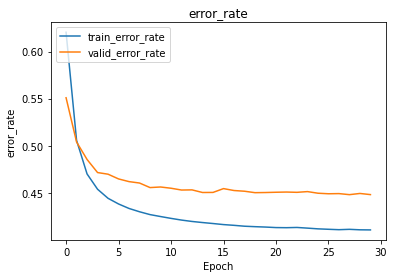

In [ ]:
plt.plot(np.ones(30)-historyx.history['accuracy'])
plt.plot(np.ones(30)-historyx.history['val_accuracy'])
plt.title('error_rate')
plt.ylabel('error_rate')
plt.xlabel('Epoch')
plt.legend(['train_error_rate','valid_error_rate'], loc='upper left')
plt.show()

In [ ]:
def generate_text(model, start_string,num_generate = 300):
    input_eval = [vocab_to_int[s] for s in start_string]
    input_eval = tf.expand_dims(input_eval, 0)
    text_generated = []
    temperature = 1.
    model.reset_states()
    for i in range(num_generate):
        predictions = model(input_eval)
        predictions = tf.squeeze(predictions, 0)
        predictions = predictions / temperature
        predicted_id = tf.random.categorical(predictions, num_samples=1)[-1,0].numpy()
        input_eval = tf.expand_dims([predicted_id], 0)
        text_generated.append(int_to_vocab[predicted_id])
    return (start_string + ''.join(text_generated))

In [ ]:
modelc1 = build_modelx(67, 256, 512, batch_size=1)
modelc1.load_weights('./training_checkpoints1/ckpt_1')
modelc3 = build_modelx(67, 256, 512, batch_size=1)
modelc3.load_weights('./training_checkpoints1/ckpt_3')
modelc5 = build_modelx(67, 256, 512, batch_size=1)
modelc5.load_weights('./training_checkpoints1/ckpt_5')
modelc10 = build_modelx(67, 256, 512, batch_size=1)
modelc10.load_weights('./training_checkpoints1/ckpt_10')
modelc20 = build_modelx(67, 256, 512, batch_size=1)
modelc20.load_weights('./training_checkpoints1/ckpt_20')
print('1')
print(generate_text(modelc1, start_string=u"DEMETRIUS:"))
print('2')
print(generate_text(modelc3, start_string=u"DEMETRIUS:"))
print('3')
print(generate_text(modelc5, start_string=u"DEMETRIUS:"))
print('4')
print(generate_text(modelc10, start_string=u"DEMETRIUS:"))
print('5')
print(generate_text(modelc20, start_string=u"DEMETRIUS:"))

1
DEMETRIUS:
IK[X,ZOXXZZ3KX&VEVACKLANTHANKzOX[KH]$XQU$XUMHX3GKKON]QUDHEKFOADEMK$$QU$VXKLXXFKXNKX$VIMPKSHAQKXXWH&QUKPHUSZM3VIBBCHKYVVOVOCHW&3[ERDUMKXXXYKXXYMUSD$BVIAMOKZEX;
K3ZHVBURVICASRKZUKINOXXEXBKINTXOUCK[HQQUVIV3HM3F3ZXZZOX]NGVODUKXGO[KZXLOXKQHENVIQUCKOAXQUVINMQUVILKL$KX&3]K:
PKINFXKCKQUTHQUCUKILK$$3XKHIXXH
2
DEMETRIUS:
DELAZCHBKY3QUXVXUP$XUCKZVZGAVILVXZRV3EVXPV3YZV3DXGXVO3VQUVEXKX]QUCMPHXV$QUXQUSIVAM[DQUTHYRVZ3VIKXQUMNGQUMVIEK:
QUEVI3DKOFLEDOCQUKBQUK$XHQAV[QUXVQUKACKIN$XXQUVKLO]3LVQUXQUVORVIXXVAXPUXQUEGXADUKXQUXZ$XV3EZZZQUVDUMVIUK:
HZAVDXVHOPHRBVGK&BYHSGKXHOGKX$x3LYXZ3VQUXV&$]&$$ZULYZGHVF[VZQUXAQUEV]3AGCKICKYRVYY
3
DEMETRIUS:
VJUGEVIHVXULXX33UCKXANQUEX$3USHXXEXEVVIXESHZAGQUEXVXW33AZPQUEDHQUXFOV3X&3UNVLVOLUCK]$$ZZQUMQUEVOX:
FOLVZQUEXH3SHAVVOLYZZQURCKXZVHVICXX3XOXUXZXX$$$]ZULXVAZG$XZ3Z3V3ZVZKLUV3SUX$X333E3Y3]CHUSX]X]J3USS$33USHUSYFRVATQURVICKXXVEXVOXX3K3HQUM$XX33YQUMXZQUNQU3UXYCVIXANGX]$]$]QUXGKLXZXEXXXXEX$XXXX]X3OX$3USHX
4
DEMETRIUS:
DUK YRANCE:
I lought for fullygo; the king hath 

In [ ]:
modelc30 = build_modelx(67, 256, 512, batch_size=1)
modelc30.load_weights(tf.train.latest_checkpoint(checkpoint_dir))
print(generate_text(modelc30, start_string=u"DEMETRIUS:",num_generate = 700))

DEMETRIUS:
She commends
him; the worst of my vot,
Transform'd by your will,
And make agree slave debair,
And then the woman mix'd,
And words have to see Donallour,
So bows, quickly, Jessica, Talbot, with said scark as good for seven knots: I'll give you this? How now! how ho, Dame Earl of Cartham?
Yet that wait in death.
Sneel.

KING HENRY V:
If you will bring our deed. Even now,
And they're it been grace,
To great Sixtreman:
We, cousin Cucelor's love,
Ford mothers with protsinting: O sir,
When I am the crown: the life, of heaven ship madoay;
For when you have used
Milonour a
gentleman. Come, cousin AEds be whe more valiantly offer! she before vowsight, a pretentice, ble?

HAMLET:
I think a
gentlew ha


In [ ]:
model2 = build_modelx(vocab_size = 67,embedding_dim=256,rnn_units=256,batch_size=batch_s)
model2.compile(optimizer='adam', loss=loss, metrics = ['accuracy'])
EPOCHS=30
history2 = model2.fit(dataset_tr, epochs=EPOCHS, validation_data = dataset_va)

Epoch 1/30
673/673 [==============================] - 67s 97ms/step - loss: 2.1672 - accuracy: 0.3851 - val_loss: 1.8894 - val_accuracy: 0.4483
Epoch 2/30
673/673 [==============================] - 66s 96ms/step - loss: 1.7578 - accuracy: 0.4821 - val_loss: 1.7436 - val_accuracy: 0.4854
Epoch 3/30
673/673 [==============================] - 68s 99ms/step - loss: 1.6458 - accuracy: 0.5119 - val_loss: 1.6807 - val_accuracy: 0.5015
Epoch 4/30
673/673 [==============================] - 67s 97ms/step - loss: 1.5882 - accuracy: 0.5271 - val_loss: 1.6473 - val_accuracy: 0.5122
Epoch 5/30
673/673 [==============================] - 67s 98ms/step - loss: 1.5524 - accuracy: 0.5365 - val_loss: 1.6304 - val_accuracy: 0.5155
Epoch 6/30
673/673 [==============================] - 71s 104ms/step - loss: 1.5284 - accuracy: 0.5424 - val_loss: 1.6194 - val_accuracy: 0.5190
Epoch 7/30
673/673 [==============================] - 69s 101ms/step - loss: 1.5111 - accuracy: 0.5467 - val_loss: 1.6123 - val_accurac

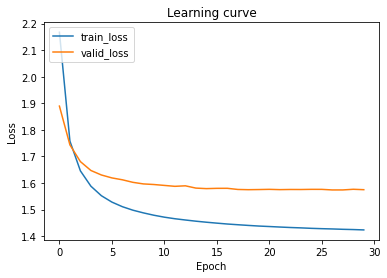

In [ ]:
plt.plot(history2.history['loss'])
plt.plot(history2.history['val_loss'])
plt.title('Learning curve')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train_loss','valid_loss'], loc='upper left')
plt.show()

In [ ]:
model2.summary()

Model: "sequential_35"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_35 (Embedding)    (64, None, 256)           17152     
                                                                 
 simple_rnn_35 (SimpleRNN)   (64, None, 256)           131328    
                                                                 
 dense_35 (Dense)            (64, None, 67)            17219     
                                                                 
Total params: 165,699
Trainable params: 165,699
Non-trainable params: 0
_________________________________________________________________


In [ ]:
seq_length1 = 200
tr_dataset1 = tf.data.Dataset.from_tensor_slices(text_as_int)
va_dataset1 = tf.data.Dataset.from_tensor_slices(text_v_as_int)
sequences_tr1 = tr_dataset1.batch(seq_length1+1, drop_remainder=True)
sequences_va1 = va_dataset1.batch(seq_length1+1, drop_remainder=True)
dataset_tr1 = sequences_tr1.map(split_input_target)
dataset_va1 = sequences_va1.map(split_input_target)
dataset_tr1 = dataset_tr1.shuffle(buffer).batch(batch_s, drop_remainder=True)
dataset_va1 = dataset_va1.batch(batch_s, drop_remainder=True)

In [ ]:
model3 = build_modelx(vocab_size = 67,embedding_dim = 256,rnn_units=512,batch_size=batch_s)
model3.compile(optimizer='adam', loss=loss, metrics = ['accuracy'])
EPOCHS=30
history3 = model3.fit(dataset_tr1, epochs=EPOCHS, validation_data = dataset_va1)

Epoch 1/30
338/338 [==============================] - 63s 178ms/step - loss: 2.3267 - accuracy: 0.3496 - val_loss: 1.9822 - val_accuracy: 0.4192
Epoch 2/30
338/338 [==============================] - 62s 177ms/step - loss: 1.8257 - accuracy: 0.4632 - val_loss: 1.7707 - val_accuracy: 0.4781
Epoch 3/30
338/338 [==============================] - 62s 176ms/step - loss: 1.6574 - accuracy: 0.5086 - val_loss: 1.6733 - val_accuracy: 0.5014
Epoch 4/30
338/338 [==============================] - 63s 181ms/step - loss: 1.5657 - accuracy: 0.5321 - val_loss: 1.6207 - val_accuracy: 0.5174
Epoch 5/30
338/338 [==============================] - 62s 177ms/step - loss: 1.5092 - accuracy: 0.5467 - val_loss: 1.5956 - val_accuracy: 0.5278
Epoch 6/30
338/338 [==============================] - 63s 180ms/step - loss: 1.4720 - accuracy: 0.5559 - val_loss: 1.5642 - val_accuracy: 0.5364
Epoch 7/30
338/338 [==============================] - 62s 176ms/step - loss: 1.4448 - accuracy: 0.5625 - val_loss: 1.5494 - val_ac

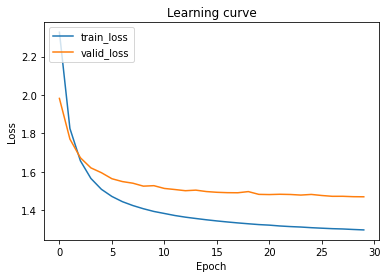

In [ ]:
plt.plot(history3.history['loss'])
plt.plot(history3.history['val_loss'])
plt.title('Learning curve')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train_loss','valid_loss'], loc='upper left')
plt.show()

In [ ]:
model3.summary()

Model: "sequential_37"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_37 (Embedding)    (64, None, 256)           17152     
                                                                 
 simple_rnn_37 (SimpleRNN)   (64, None, 512)           393728    
                                                                 
 dense_37 (Dense)            (64, None, 67)            34371     
                                                                 
Total params: 445,251
Trainable params: 445,251
Non-trainable params: 0
_________________________________________________________________


In [ ]:
def build_model(vocab_size, embedding_dim, rnn_units, batch_size):
  model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim,
                              batch_input_shape=[batch_size, None]),
    tf.keras.layers.LSTM(rnn_units,
                        return_sequences=True,
                        stateful=True,
                        recurrent_initializer='glorot_uniform'),
    tf.keras.layers.Dense(vocab_size)
  ])
  return model


In [ ]:
model = build_model(vocab_size = 67,embedding_dim = 256,rnn_units = 512,batch_size=batch_s)
model.compile(optimizer='adam', loss=loss, metrics = ['accuracy'])

In [ ]:
checkpoint_dir1 = './training_checkpoint'
checkpoint_prefix1 = os.path.join(checkpoint_dir1, "ckpt_{epoch}")
checkpoint_callback1=tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_prefix1,save_weights_only=True)

In [ ]:
EPOCHS=30
history = model.fit(dataset_tr, epochs=EPOCHS, validation_data = dataset_va,callbacks=[checkpoint_callback1])

Epoch 1/30
673/673 [==============================] - 22s 28ms/step - loss: 2.1174 - accuracy: 0.3955 - val_loss: 1.7361 - val_accuracy: 0.4865
Epoch 2/30
673/673 [==============================] - 19s 26ms/step - loss: 1.5670 - accuracy: 0.5325 - val_loss: 1.5695 - val_accuracy: 0.5306
Epoch 3/30
673/673 [==============================] - 19s 27ms/step - loss: 1.4454 - accuracy: 0.5636 - val_loss: 1.5136 - val_accuracy: 0.5465
Epoch 4/30
673/673 [==============================] - 20s 28ms/step - loss: 1.3925 - accuracy: 0.5766 - val_loss: 1.4861 - val_accuracy: 0.5544
Epoch 5/30
673/673 [==============================] - 22s 31ms/step - loss: 1.3607 - accuracy: 0.5844 - val_loss: 1.4729 - val_accuracy: 0.5575
Epoch 6/30
673/673 [==============================] - 23s 32ms/step - loss: 1.3382 - accuracy: 0.5900 - val_loss: 1.4618 - val_accuracy: 0.5611
Epoch 7/30
673/673 [==============================] - 22s 30ms/step - loss: 1.3213 - accuracy: 0.5942 - val_loss: 1.4580 - val_accuracy:

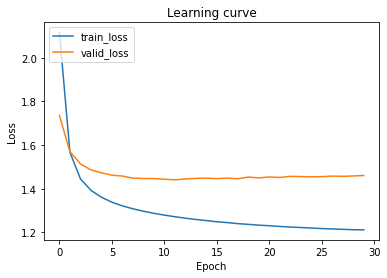

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Learning curve')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train_loss','valid_loss'], loc='upper left')
plt.show()

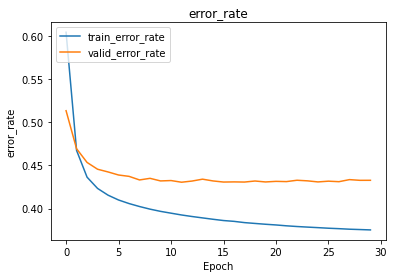

In [ ]:
plt.plot(np.ones(30)-history.history['accuracy'])
plt.plot(np.ones(30)-history.history['val_accuracy'])
plt.title('error_rate')
plt.ylabel('error_rate')
plt.xlabel('Epoch')
plt.legend(['train_error_rate','valid_error_rate'], loc='upper left')
plt.show()

In [ ]:
model.summary()

Model: "sequential_38"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_38 (Embedding)    (64, None, 256)           17152     
                                                                 
 lstm (LSTM)                 (64, None, 512)           1574912   
                                                                 
 dense_38 (Dense)            (64, None, 67)            34371     
                                                                 
Total params: 1,626,435
Trainable params: 1,626,435
Non-trainable params: 0
_________________________________________________________________


In [ ]:
modela11 = build_model(67, 256, 512, batch_size=1)
modela11.load_weights('./training_checkpoint/ckpt_1')
modela33 = build_model(67, 256, 512, batch_size=1)
modela33.load_weights('./training_checkpoint/ckpt_3')
modela55 = build_model(67, 256, 512, batch_size=1)
modela55.load_weights('./training_checkpoint/ckpt_5')
modela100 = build_model(67, 256, 512, batch_size=1)
modela100.load_weights('./training_checkpoint/ckpt_10')
modela200 = build_model(67, 256, 512, batch_size=1)
modela200.load_weights('./training_checkpoint/ckpt_20')
print('1')
print(generate_text(modela11, start_string=u"DEMETRIUS:"))
print('2')
print(generate_text(modela33, start_string=u"DEMETRIUS:"))
print('3')
print(generate_text(modela55, start_string=u"DEMETRIUS:"))
print('4')
print(generate_text(modela100, start_string=u"DEMETRIUS:"))
print('5')
print(generate_text(modela200, start_string=u"DEMETRIUS:"))

1
DEMETRIUS:
Benierty that thou forte rouns of dy, to thy wark.

Bercomn:
Well tife well infort;
Sir frantonours, epes!
I cummand for blood, Lucious and the be:

MOSTILLASS:
Wearst's dears: or out fairts.

PORTROUCUS:
Shiling the fallow. Gove loves?

Lord Harry, then you!
Most ramial confing.

KING CEMAIUS:
At 
2
DEMETRIUS:
Here's my hothfully: this make of roous intervice?

Fool:
'Tis no clotinBit they will behole
and can, you is your MurberGow's, doth from health.

FALSTAFF:
Speak, so ppoise both I was gone.

ORLEANS:
Withou well beyond the four gifthy nighty!
To forson in the world. Take it me, out so? should emplo
3
DEMETRIUS:

Lord Chirpenses
hath am dishred upon me: I shall say

ULYSSES:
Well, she into it as Easy of the thiek?

ALIXE:
What 'twixt be that a chide of Christing three hast think'd a cusper--

YORK:
Is it one can lead that had daughters.
It is trues crackly let him gubers.
Here is this Sir John!

MOTH:
Fran
4
DEMETRIUS:
Thanks, my lord, as said so I speak of
To wed hi

In [ ]:
modela300 = build_model(67, 256, 512, batch_size=1)
modela300.load_weights(tf.train.latest_checkpoint(checkpoint_dir1))
print(generate_text(modela300, start_string=u"DEMETRIUS:",num_generate = 700))

DEMETRIUS:
Your will is torman-place.

GLOUCESTER:
There's nothing but for the quick mouth.

RODERIGO:
Is it Henry's death.

BELARIUS:
Ha! ha! have your majesty not young?

PANDARUS:
Alain my crown, thy friend provided thy two doubts,
Plays noble gull his friends, but he's not the peyouse carrow of the way;
Hearing of weaker thought's side of courage,
Dred his face. Show me thy glories up thy faultings tooc, which
Hath brought 'em gardet, with thy greater guide,
Redeeming such a nobber in my side.

MOTH:
Truly.

COUNTESS:
Remember this eyes, which hath some half an horrib days:
But in pittion is in my colours,
Killing thee, hidpents of Achilles call them spoils?
Farewell to Cade slave of this me for t


In [ ]:
model21 = build_model(vocab_size = 67,embedding_dim = 256,rnn_units = 256,batch_size=batch_s)
model21.compile(optimizer='adam', loss=loss, metrics = ['accuracy'])
EPOCHS=30
history21 = model21.fit(dataset_tr, epochs=EPOCHS, validation_data = dataset_va)

Epoch 1/30
673/673 [==============================] - 15s 19ms/step - loss: 2.1173 - accuracy: 0.3950 - val_loss: 1.7772 - val_accuracy: 0.4766
Epoch 2/30
673/673 [==============================] - 13s 18ms/step - loss: 1.6314 - accuracy: 0.5152 - val_loss: 1.6281 - val_accuracy: 0.5157
Epoch 3/30
673/673 [==============================] - 13s 18ms/step - loss: 1.5177 - accuracy: 0.5453 - val_loss: 1.5764 - val_accuracy: 0.5298
Epoch 4/30
673/673 [==============================] - 13s 18ms/step - loss: 1.4657 - accuracy: 0.5584 - val_loss: 1.5439 - val_accuracy: 0.5373
Epoch 5/30
673/673 [==============================] - 13s 18ms/step - loss: 1.4353 - accuracy: 0.5660 - val_loss: 1.5255 - val_accuracy: 0.5447
Epoch 6/30
673/673 [==============================] - 14s 19ms/step - loss: 1.4146 - accuracy: 0.5711 - val_loss: 1.5112 - val_accuracy: 0.5477
Epoch 7/30
673/673 [==============================] - 13s 18ms/step - loss: 1.3995 - accuracy: 0.5749 - val_loss: 1.5080 - val_accuracy:

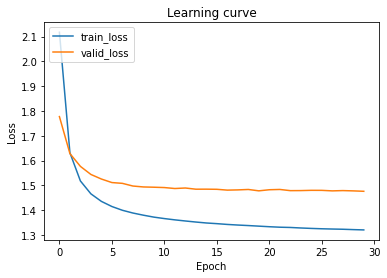

In [ ]:
plt.plot(history21.history['loss'])
plt.plot(history21.history['val_loss'])
plt.title('Learning curve')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train_loss','valid_loss'], loc='upper left')
plt.show()

In [ ]:
model21.summary()

Model: "sequential_39"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_39 (Embedding)    (64, None, 256)           17152     
                                                                 
 lstm_1 (LSTM)               (64, None, 256)           525312    
                                                                 
 dense_39 (Dense)            (64, None, 67)            17219     
                                                                 
Total params: 559,683
Trainable params: 559,683
Non-trainable params: 0
_________________________________________________________________


In [ ]:
model22 = build_model(vocab_size = 67,embedding_dim = 256,rnn_units = 512,batch_size=batch_s)
model22.compile(optimizer='adam', loss=loss, metrics = ['accuracy'])
EPOCHS=30
history22 = model22.fit(dataset_tr1, epochs=EPOCHS, validation_data = dataset_va1)

Epoch 1/30
338/338 [==============================] - 20s 49ms/step - loss: 2.3893 - accuracy: 0.3326 - val_loss: 1.9401 - val_accuracy: 0.4316
Epoch 2/30
338/338 [==============================] - 19s 50ms/step - loss: 1.7372 - accuracy: 0.4858 - val_loss: 1.6683 - val_accuracy: 0.5020
Epoch 3/30
338/338 [==============================] - 19s 49ms/step - loss: 1.5344 - accuracy: 0.5407 - val_loss: 1.5630 - val_accuracy: 0.5326
Epoch 4/30
338/338 [==============================] - 19s 49ms/step - loss: 1.4426 - accuracy: 0.5644 - val_loss: 1.5147 - val_accuracy: 0.5479
Epoch 5/30
338/338 [==============================] - 19s 49ms/step - loss: 1.3913 - accuracy: 0.5772 - val_loss: 1.4871 - val_accuracy: 0.5553
Epoch 6/30
338/338 [==============================] - 19s 49ms/step - loss: 1.3579 - accuracy: 0.5852 - val_loss: 1.4696 - val_accuracy: 0.5609
Epoch 7/30
338/338 [==============================] - 19s 48ms/step - loss: 1.3334 - accuracy: 0.5911 - val_loss: 1.4553 - val_accuracy:

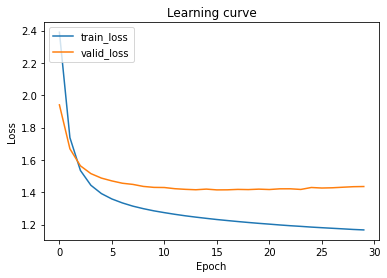

In [ ]:
plt.plot(history22.history['loss'])
plt.plot(history22.history['val_loss'])
plt.title('Learning curve')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train_loss','valid_loss'], loc='upper left')
plt.show()

In [ ]:
model22.summary()

Model: "sequential_40"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_40 (Embedding)    (64, None, 256)           17152     
                                                                 
 lstm_2 (LSTM)               (64, None, 512)           1574912   
                                                                 
 dense_40 (Dense)            (64, None, 67)            34371     
                                                                 
Total params: 1,626,435
Trainable params: 1,626,435
Non-trainable params: 0
_________________________________________________________________
